# Overview
1. Input data is the enriched CVSS score with the Exploit Code Maturity/Exploitability (E) Temporal Metric cvss-bt.csv from https://github.com/t0sche/cvss-bt
2. Percentile for a set of CVEs
3. EPSS vs CVSS color-coded by data sources e.g. red for CISA KEV, etc... 
4. interactive zoomable/rotatable scatter plot of EPSS vs CVSS score - sliders on both EPSS and CVSS so users can see the effect of different thresholds

In [74]:
# Need these for the logic
import pandas as pd
import numpy as np

# suppress error for environment variable APPDATA missing on OSs other than Windows
import os
os.environ['APPDATA'] = ""
import pandasgui

# Need these for the plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from IPython.display import Image #to display images in github from this notebook

EPSS_THRESHOLD_LOW = 0.1


# CVSS

In [75]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Run code specific to Google Colab environment
    print("Running in Google Colab")
    #Download the input data file
    FILE_PATH="./cvss-bt.csv"
    URL="https://raw.githubusercontent.com/t0sche/cvss-bt/main/cvss-bt.csv"

    !if [ ! -f $FILE_PATH ]; then \
        wget -O $FILE_PATH $URL; \
    else \
        echo "File already exists: $FILE_PATH"; \
    fi
    df = pd.read_csv('./cvss-bt.csv')
else:
    # Run code for other environments
    print("Not running in Google Colab")
    df = pd.read_csv('../data_in/cvss_bt/cvss-bt.csv.gz', compression="gzip")


Not running in Google Colab


/var/folders/ss/mvst4cws5c9dzhhthv64hhzr0000gq/T/ipykernel_36010/3682874487.py:19: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



In [76]:
df

,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github
0,CVE-1999-0095,9.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:POC,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-10-01T04:00Z,0.07764,False,False,True,False,False,False
1,CVE-1999-0082,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-11-11T05:00Z,0.015,False,False,False,False,False,False
2,CVE-1999-1471,6.1,MEDIUM,AV:L/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,7.2,HIGH,AV:L/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-01-01T05:00Z,0.00043,False,False,False,False,False,False
3,CVE-1999-1122,3.9,LOW,AV:L/AC:L/Au:N/C:P/I:P/A:P/E:U,2.0,4.6,MEDIUM,AV:L/AC:L/Au:N/C:P/I:P/A:P,cve@mitre.org,1989-07-26T04:00Z,0.0006,False,False,False,False,False,False
4,CVE-1999-1467,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-10-26T04:00Z,0.00299,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240311,CVE-2023-49602,5.0,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N/E:U,3.1,5.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False
240312,CVE-2024-21816,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False
240313,CVE-2024-21826,7.3,HIGH,CVSS:3.1/AV:A/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.0,HIGH,CVSS:3.1/AV:A/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False
240314,CVE-2023-46708,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False


In [77]:
# Drop rows where 'cvss' column value is zero
df = df[df['base_score'] != 0]
df = df[df['cvss-bt_score'] != 0]
df

,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github
0,CVE-1999-0095,9.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:POC,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-10-01T04:00Z,0.07764,False,False,True,False,False,False
1,CVE-1999-0082,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-11-11T05:00Z,0.015,False,False,False,False,False,False
2,CVE-1999-1471,6.1,MEDIUM,AV:L/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,7.2,HIGH,AV:L/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-01-01T05:00Z,0.00043,False,False,False,False,False,False
3,CVE-1999-1122,3.9,LOW,AV:L/AC:L/Au:N/C:P/I:P/A:P/E:U,2.0,4.6,MEDIUM,AV:L/AC:L/Au:N/C:P/I:P/A:P,cve@mitre.org,1989-07-26T04:00Z,0.0006,False,False,False,False,False,False
4,CVE-1999-1467,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-10-26T04:00Z,0.00299,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240311,CVE-2023-49602,5.0,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N/E:U,3.1,5.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False
240312,CVE-2024-21816,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False
240313,CVE-2024-21826,7.3,HIGH,CVSS:3.1/AV:A/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.0,HIGH,CVSS:3.1/AV:A/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False
240314,CVE-2023-46708,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False


In [78]:
# Convert the column to float with coercion
df['epss'] = pd.to_numeric(df['epss'], errors='coerce')

## CVSS Ratings

In [79]:
# Define function to categorize scores
def categorize_score(score):
    if score >= 0.1 and score <= 3.9:
        return 'low'
    elif score >= 4.0 and score <= 6.9:
        return 'medium'
    elif score >= 7.0 and score <= 8.9:
        return 'high'
    elif score >= 9.0 and score <= 10.0:
        return 'critical'
    else:
        return 'invalid'



# Add Exploitability column to indicate the exploitability source 

In [80]:
def map_exploitation(row):
    if (row['cisa_kev']):
        return 7
    elif (row['vulncheck_kev']):
        return 6
    elif (row['metasploit'] & row['nuclei']):
        return 5
    elif (row['metasploit']):
        return 4
    elif (row['nuclei']):
        return 3
    elif (row['exploitdb']):
        return 2
    elif (row['poc_github']):
        return 1
    else:
        return 0

# Apply the function to create the 'exploitation' column
df['exploitation'] = df.apply(map_exploitation, axis=1)
df['exploitation'].value_counts()


0    211658
2     19743
1      3329
4      1842
3      1658
7      1083
6       881
5        83
Name: exploitation, dtype: int64

In [81]:
def map_exploitation(row):
    if (row['cisa_kev'] | row['vulncheck_kev']):
        return 3
    elif (row['metasploit'] | row['nuclei']):
        return 2
    elif (row['exploitdb'] | row['poc_github']):
        return 1
    else:
        return 0

# Apply the function to create the 'exploitation' column
df['exploitation'] = df.apply(map_exploitation, axis=1)
df['exploitation'].value_counts()


0    211658
1     23072
2      3583
3      1964
Name: exploitation, dtype: int64

Text(0.5, 0.98, 'CVSS scores vs EPSS')

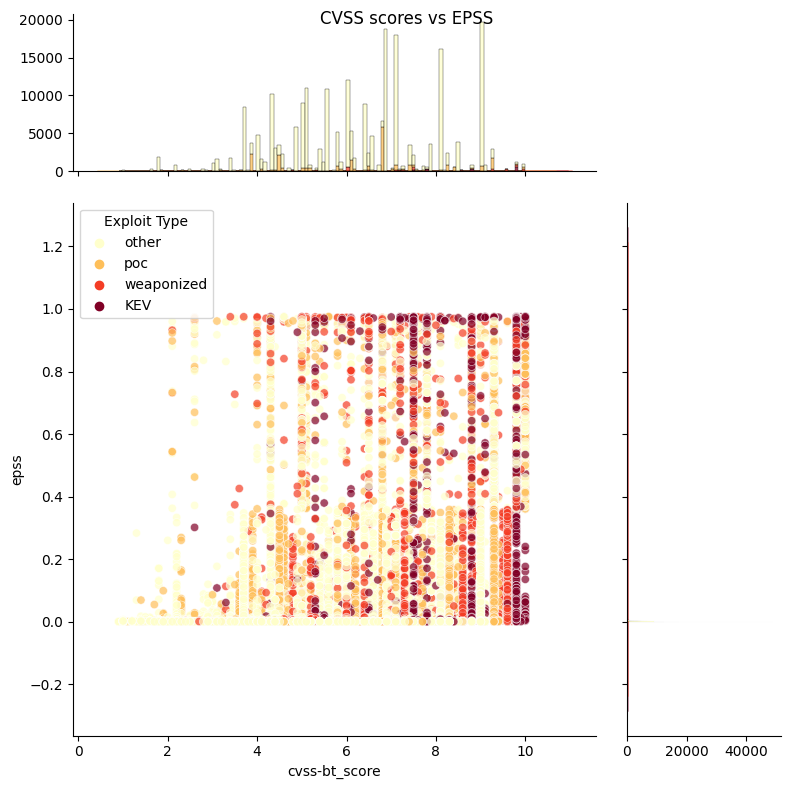

In [82]:
colorscale = 'YlOrRd' #Yellow Orange Red
g=sns.jointplot(data=df, x='cvss-bt_score', y='epss', kind='scatter', height=8, ratio=3, marginal_ticks=True, alpha=.7, hue="exploitation", palette=colorscale)
handles, labels = g.ax_joint.get_legend_handles_labels()
#g.ax_joint.legend(handles=handles, labels = ['CISA KEV', 'VulnCheck KEV', 'both metasploit & nuclei', 'metasploit', 'nuclei', 'exploitdb', 'poc_github', 'other'], title="Exploit Type")
#g.ax_joint.legend(handles=handles, labels = ['other', 'poc_github', 'exploitdb', 'nuclei', 'metasploit', 'both metasploit & nuclei', 'VulnCheck KEV', 'CISA KEV'], title="Exploit Type")
g.ax_joint.legend(handles=handles, labels = ['other', 'poc', 'weaponized',  'KEV'], title="Exploit Type")


g.plot_marginals(sns.histplot, multiple="stack")
g.fig.suptitle("CVSS scores vs EPSS")

## EPSS Curve

In [83]:
filtered_df = df[~(df['cisa_kev'] | df['vulncheck_kev'] | df['metasploit'] | df['nuclei'])]
filtered_df

,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github,exploitation
0,CVE-1999-0095,9.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:POC,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-10-01T04:00Z,0.07764,False,False,True,False,False,False,1
1,CVE-1999-0082,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-11-11T05:00Z,0.01500,False,False,False,False,False,False,0
2,CVE-1999-1471,6.1,MEDIUM,AV:L/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,7.2,HIGH,AV:L/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-01-01T05:00Z,0.00043,False,False,False,False,False,False,0
3,CVE-1999-1122,3.9,LOW,AV:L/AC:L/Au:N/C:P/I:P/A:P/E:U,2.0,4.6,MEDIUM,AV:L/AC:L/Au:N/C:P/I:P/A:P,cve@mitre.org,1989-07-26T04:00Z,0.00060,False,False,False,False,False,False,0
4,CVE-1999-1467,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-10-26T04:00Z,0.00299,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240311,CVE-2023-49602,5.0,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N/E:U,3.1,5.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False,0
240312,CVE-2024-21816,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False,0
240313,CVE-2024-21826,7.3,HIGH,CVSS:3.1/AV:A/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.0,HIGH,CVSS:3.1/AV:A/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False,0
240314,CVE-2023-46708,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False,0


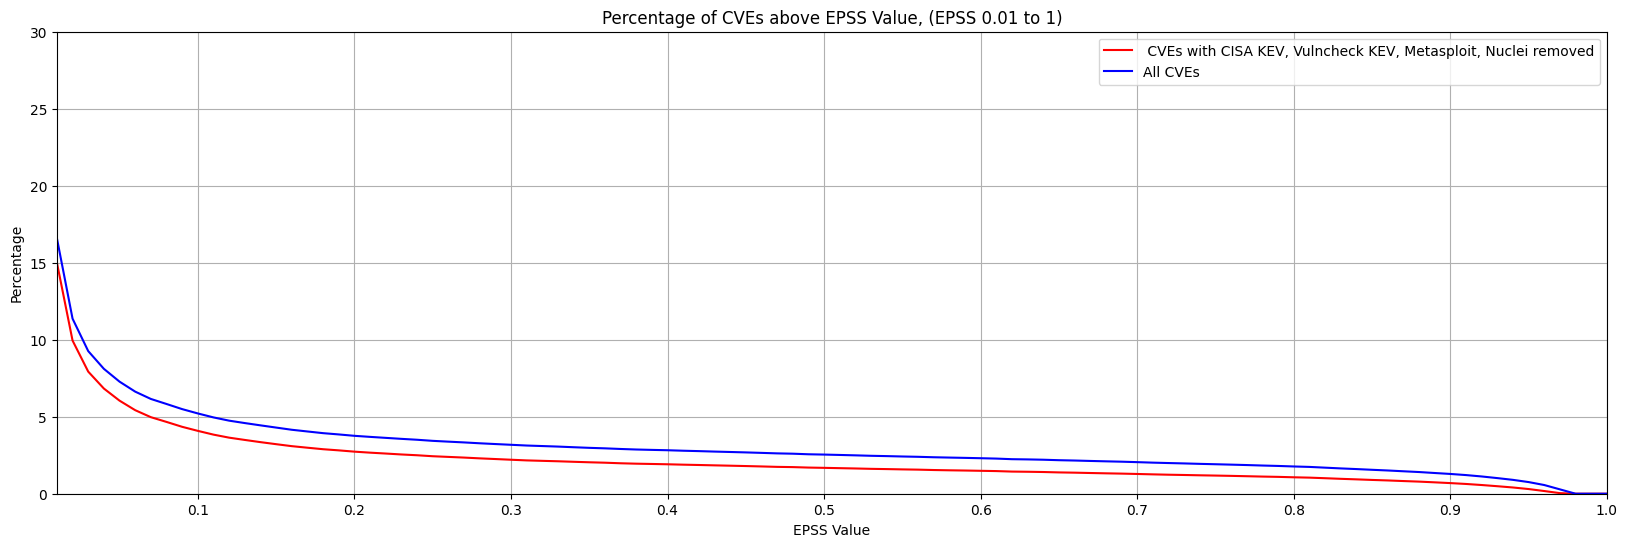

In [84]:
import numpy as np  # Import NumPy for array operations

# Define the range of values from 0 to 1
value_range = np.linspace(0, 1, 101)  # Values from 0.00 to 1.00 in steps of 0.01

# Calculate total count for normalization
total_count = len(df['epss'])

# Calculate cumulative percentages for each value in the range
cumulative_percentages = [((df['epss'] >= value).sum() / total_count) * 100 for value in value_range]

# Calculate cumulative percentages for filtered data
cumulative_percentages_filtered = [((filtered_df['epss'] >= value).sum() / total_count) * 100 for value in value_range]

# Create a cumulative histogram
plt.figure(figsize=(20, 6))

plt.plot(value_range, cumulative_percentages_filtered, linestyle='-', color='r', label=' CVEs with CISA KEV, Vulncheck KEV, Metasploit, Nuclei removed')
plt.plot(value_range, cumulative_percentages, linestyle='-', color='b', label='All CVEs')

plt.title('Percentage of CVEs above EPSS Value, (EPSS 0.01 to 1)')
plt.xlabel('EPSS Value')
plt.ylabel('Percentage')
plt.yscale('linear')
plt.xlim(0.01, 1)
plt.ylim(0, 30)  # Adjust ylim to show percentages from 0 to 100

plt.xticks(np.arange(0.1, 1.1, 0.1))  # Set major ticks at every 0.1 step on the x-axis


plt.grid(True)
plt.legend()
plt.show()

## EPSS Percentiles

In [85]:
def percentile_rank(column):
   return column.rank(pct = True)

In [86]:
df['Percentile'] = percentile_rank(df['epss'])
df

,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github,exploitation,Percentile
0,CVE-1999-0095,9.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:POC,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-10-01T04:00Z,0.07764,False,False,True,False,False,False,1,0.940186
1,CVE-1999-0082,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-11-11T05:00Z,0.01500,False,False,False,False,False,False,0,0.865524
2,CVE-1999-1471,6.1,MEDIUM,AV:L/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,7.2,HIGH,AV:L/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-01-01T05:00Z,0.00043,False,False,False,False,False,False,0,0.067201
3,CVE-1999-1122,3.9,LOW,AV:L/AC:L/Au:N/C:P/I:P/A:P/E:U,2.0,4.6,MEDIUM,AV:L/AC:L/Au:N/C:P/I:P/A:P,cve@mitre.org,1989-07-26T04:00Z,0.00060,False,False,False,False,False,False,0,0.232693
4,CVE-1999-1467,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-10-26T04:00Z,0.00299,False,False,False,False,False,False,0,0.687800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240311,CVE-2023-49602,5.0,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N/E:U,3.1,5.4,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:L/UI:R/S:C/C:L/I:L/A:N,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False,0,0.067201
240312,CVE-2024-21816,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False,0,0.067201
240313,CVE-2024-21826,7.3,HIGH,CVSS:3.1/AV:A/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.0,HIGH,CVSS:3.1/AV:A/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False,0,0.067201
240314,CVE-2023-46708,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,scy@openharmony.io,2024-03-04T07:15Z,0.00043,False,False,False,False,False,False,0,0.067201


# Sanity check against today's EPSS percentile values
use first entries in df

In [87]:
# 0.940186
!curl 'https://api.first.org/data/v1/epss?cve=CVE-1999-0095' | jq -r '.data[].percentile'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   202  100   202    0     0    285      0 --:--:-- --:--:-- --:--:--   286
0.940170000


In [88]:
# 0.865524
!curl 'https://api.first.org/data/v1/epss?cve=CVE-1999-0082' | jq -r '.data[].percentile'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   202  100   202    0     0    404      0 --:--:-- --:--:-- --:--:--   404
0.866030000
